## Overfitting
- loss=0, bias or noise까지 학습?

### Validation Set
 - Data를 random split 하여 train / valid set 구성
 - 매 epoch 마다 validation error를 측정하여 평가

### Test Set
- test
- 일반적으로 train : valid : test = 6 : 2 : 2

## Underfitting
- 모델의 traing error 마저도 높은 경우
- model의 capacity의 문제
  - model의 depth, width의 문제

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['TARGET'] = california.target

df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data = torch.from_numpy(df.values).float()

In [6]:
x = data[:, :-1]
y = data[:, -1:]

x.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [9]:
ratios = [.6, .2, .2]

In [11]:
train_cnt = int(data.shape[0] * ratios[0])
valid_cnt = int(data.shape[0] * ratios[1])
test_cnt = data.shape[0] - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train %d / Valid %d / Test %d samples' % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples


In [12]:
indices = torch.randperm(data.shape[0])
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [13]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,0.951174,-0.925928,0.567313,-0.003163,0.573432,0.006928,-0.637097,0.194210
12380,-0.581863,-1.084874,-0.569800,0.172788,-0.080215,-0.002059,-0.936228,0.817079
12381,-0.539334,-0.925928,-0.044522,-0.072625,1.277426,-0.094220,1.274540,-1.181087
12382,0.646155,-1.561713,0.421435,-0.159819,1.693225,0.038038,1.017475,-0.832278
12383,-1.227848,1.855630,-0.535617,-0.177770,-0.301569,-0.003390,-0.767966,0.632709


In [44]:
model = nn.Sequential(
    nn.Linear(x[0].shape[-1], 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].shape[-1])
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [45]:
optimizer = optim.Adam(model.parameters())

In [46]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [47]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [48]:
train_history, valid_history = [], []

for i in range(n_epochs):
    
    indices = torch.randperm(x[0].shape[0])
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)
    
    # Valid data는 gradient를 진행하지 않음, 학습을 진행하지 않기 때문에 / 속도, 메모리 효율
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            # Gradient is already detached
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else :
        if (i + 1 - lowest_epoch) > early_stop and early_stop > 0:
            print("There is no improvement during last %d epochs." % early_stop)
            break
            
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

Epoch 100: train loss=3.9062e-01  valid_loss=4.2046e-01  lowest_loss=4.1976e-01
Epoch 200: train loss=3.7940e-01  valid_loss=4.0546e-01  lowest_loss=4.0543e-01
Epoch 300: train loss=3.7467e-01  valid_loss=4.0191e-01  lowest_loss=4.0138e-01
Epoch 400: train loss=3.7408e-01  valid_loss=3.9943e-01  lowest_loss=3.9935e-01
Epoch 500: train loss=3.7304e-01  valid_loss=3.9900e-01  lowest_loss=3.9865e-01
Epoch 600: train loss=3.7146e-01  valid_loss=3.9997e-01  lowest_loss=3.9845e-01
Epoch 700: train loss=3.7132e-01  valid_loss=3.9835e-01  lowest_loss=3.9822e-01
Epoch 800: train loss=3.7302e-01  valid_loss=3.9809e-01  lowest_loss=3.9801e-01
Epoch 900: train loss=3.7163e-01  valid_loss=3.9855e-01  lowest_loss=3.9788e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 841: 3.9788e-01


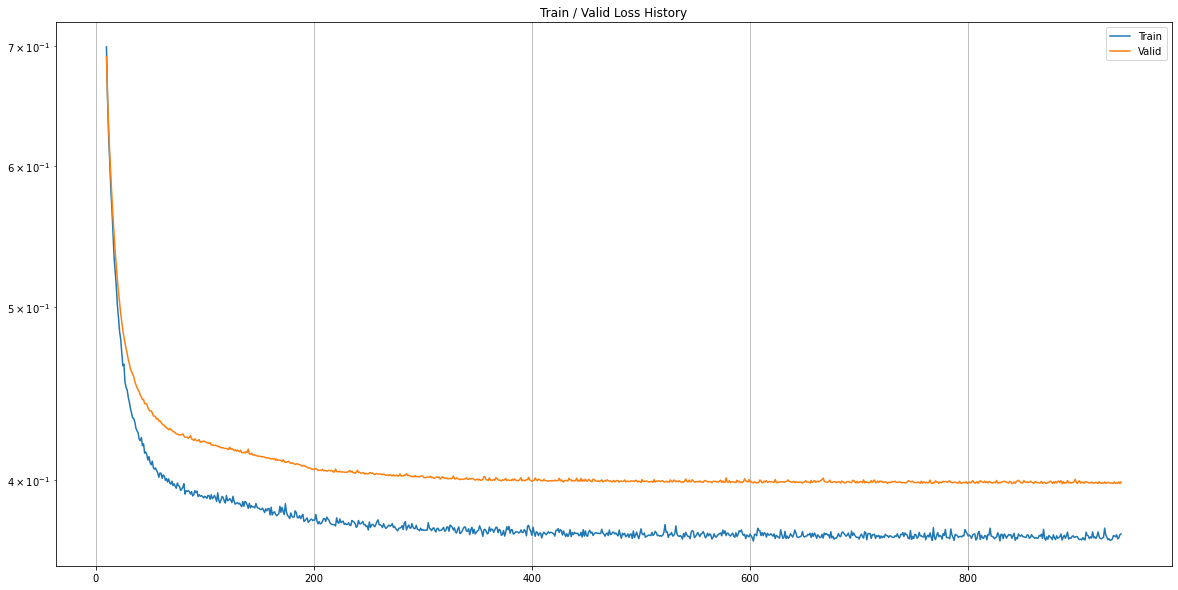

In [49]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")

plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:], label='Train'
)
plt.plot(
    range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid'
)
plt.yscale('log')
plt.legend()
plt.show()

In [51]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += loss
        
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 3.7077e-01
Valid loss: 3.9788e-01
Test loss: 3.9025e-01


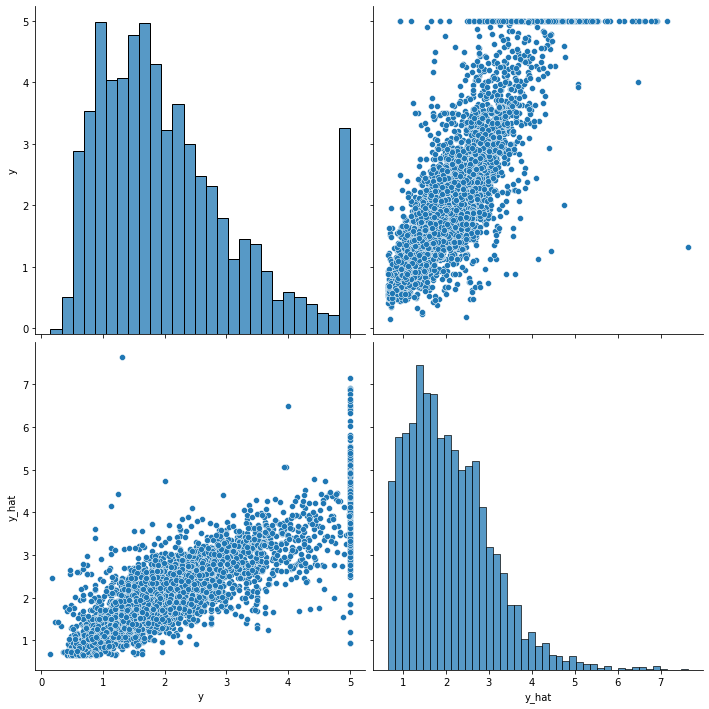

In [52]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=['y', 'y_hat'])

sns.pairplot(df, height=5)
plt.show()